# Regression case study with Bayesian Neural Networks

**Goal:** In this notebook you will investigate the advantages Bayesian NNs offer in a regression task for a Normal Distributed CPD. First, you fit a "traditional" non-Bayesian NN and then you will fit two Bayesian NN, one via *variational inference* and one via *MC-dropout*. You will compare the results of the different models, especially you will have a look at the extrapolation case.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** 
A simulated dataset with a sine wave that has a small positive linear trend and a variance that depends on the amplitude.

**Content:**
* Simulate the data set
* Fit a non-Bayesian regression model.
* Fit a Bayesian regression model via variational inference. 
* Fit a Bayesian regression model via mc dropout.
* Comparing the predictive distribution of the three approaches


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb)

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [3]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

#### Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.0.0


## Data generation

Here, we use the same data generation function, that we already used in chapter 4 and in the notebook https://github.com/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_04.ipynb 

376

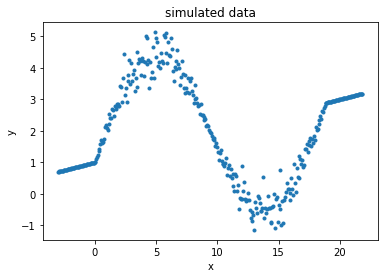

In [5]:
def create_sine_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

## use custom function to simulate some data 
x,y = create_sine_data(256) # Note that the model has been trained with 2048 data points
plt.scatter(x=x,y=y,marker='.',alpha=1)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)
n

## Non-Bayesian (just aleatoric)

We create a non-Bayesian model for the mean $\mu_x$ and the standard deviation $\sigma_x$ of a Gaussian. We use the same model, which we used in chapter https://github.com/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_04.ipynb but this time, we define the output with tensorflow probability.

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def NLL(y, distr): 
  return -distr.log_prob(y) 

def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_nobay = Model(inputs=inputs, outputs=dist)
model_nobay.compile(Adam(), loss=NLL) 

In [7]:
model_nobay.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
___________________________________________________________

In [8]:
### Training takes some time
# history = model_nobay.fit(x, y, epochs=5000, verbose=0,batch_size=32)
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.show()

In [9]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5", "model_nobay.hdf5")
model_nobay.load_weights("model_nobay.hdf5")

In [10]:
model_nobay = Model(inputs=inputs, outputs=dist.sample())

In [11]:
x_pred = np.arange(-10,30,0.3) 
for rep in range(2): #Predictions for two runs
    print(model_nobay.predict(x_pred)[0:3].T) 

[[0.16900493 0.21310014 0.20449556]]
[[0.18963961 0.18537523 0.18922774]]


All the weights in the network are fixed. We still get different predictions for the two runs, since we sample from the Gaussian posterior. This reflects the alleatoric uncertainty. 

Now we do more runs and store the results for plotting.

In [12]:
runs = 200
nobay_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    nobay_cpd[i,:]=np.reshape(model_nobay.predict(x_pred),len(x_pred))

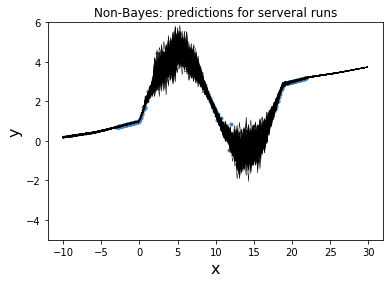

In [13]:
def make_plot_runs(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    for i in range(0,preds.shape[0]):
      ax.plot(x_pred, preds[i],color="black",linewidth=.5)
    ax.set_ylim(ylim)
  
ax = plt.subplot()
make_plot_runs(ax, nobay_cpd)
plt.ylim([-5,6])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Non-Bayes: predictions for serveral runs')
plt.show()

This plot is quite cluttered. Let's create the summary statistics to make it less cluttered.

In [14]:
np.quantile(nobay_cpd, 0.025, axis=0)

array([ 0.14290223,  0.16529014,  0.18073766,  0.18994608,  0.20583691,
        0.23837794,  0.24412078,  0.26647516,  0.28630655,  0.30552114,
        0.31742246,  0.34031336,  0.35614916,  0.36521298,  0.3891602 ,
        0.41698002,  0.45104262,  0.48124113,  0.50420825,  0.53780719,
        0.56796889,  0.59507182,  0.62367758,  0.64998776,  0.68336336,
        0.71343227,  0.75083536,  0.78184061,  0.81298684,  0.84126083,
        0.87044876,  0.90382497,  0.9342766 ,  0.96263174,  1.18746953,
        1.46532876,  1.80996774,  1.97944326,  2.22499075,  2.39400145,
        2.47045972,  2.67875499,  2.77756284,  2.93521198,  2.98047037,
        3.22487173,  3.24565592,  3.29581485,  3.24586294,  3.44945402,
        3.95027486,  3.86144201,  3.79260437,  3.67449172,  3.60747927,
        3.39094592,  3.30479302,  3.25169102,  3.15302818,  2.99552469,
        2.86426523,  2.61613201,  2.43432733,  2.19842667,  2.02671065,
        1.74343621,  1.45748926,  1.16575   ,  0.8525947 ,  0.58

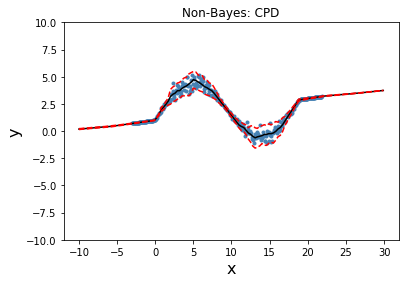

In [15]:
def make_plot_runs_avg(ax, preds, alpha_data=1,ylim=[-7,8]):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd      
    ax.set_ylim(ylim)
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=1.5)
    ax.plot(x_pred,np.quantile(preds, 0.025, axis=0),color="red",linewidth=1.5,linestyle="--")
    ax.plot(x_pred,np.quantile(preds, 0.975, axis=0),color="red",linewidth=1.5,linestyle="--")

ax = plt.subplot()
make_plot_runs_avg(ax, nobay_cpd)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title('Non-Bayes: CPD')
plt.show()

## Bayesian Model using VI

Now we will train a bayesian neural network via variational inference. We again use the same architecture as above. But now instead of weights, we approximate the posterior of the weights with a normal distribution. 

The normal distribution has two paramters and therefore, we have almost doubled our paramters (we don't use a distribution for bias terms) in the network.  Because the training takes a lot of time, you will load an already trained network with the learning curve.


The model `model_vi` it self is the CPD of $y$ given by $p(y|x) = N(y,\mu_x,\sigma_x)$

In [16]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(learning_rate=0.0002), loss=NLL) 

model_params = Model(inputs=inputs, outputs=params)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [17]:
model_vi.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 20)                80        
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 50)                2100      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 20)                2040      
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 2)                 84        
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 4,304
Trainable params: 4,304
Non-trainable params: 0
_________________________________________________________

In [18]:
# from time import time
# start = time()
# Note that the model has been trained with 2048 data points
# history = model_vi.fit(x, y, epochs=20000, verbose=0,batch_size=512)
# print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_vi.hdf5')
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# model_vi.save_weights('model_vi.hdf5')
# plt.show()

In [19]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi.hdf5", "model_vi.hdf5")
model_vi.load_weights("model_vi.hdf5")

In [20]:
for rep in range(2):
    print(model_vi.predict(x_pred)[0:3].T) #Samples from the posteriori predictive distribution, different for each run

[[-1.5350035   0.91246146  0.65342474]]
[[1.723244  1.7290317 4.2111816]]


In the next cell you can see that you also get a different prediction for the parameters, mean $\mu$ and standarddev $\sigma$ changes a bit. 

In [21]:
for rep in range(2):
    print(model_params.predict(x_pred)[0:3].T) #Samples from the parameters for the post predictive, different for each run

[[   1.9432766    0.7739976    3.44338  ]
 [ -99.38898   -123.99784    -83.87831  ]]
[[  0.4320022   -0.27698755   0.9862267 ]
 [-35.46659    -56.81727    -67.87841   ]]


### The CPD for several runs

Let's draw samples form the CPD, which we need for the plot below.

In [22]:
vi_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

## MC Dropout

We repeat the analysis from above but this time using MC-Dropout instead of VI. And compare the results with the VI Bayesian network and the non-Bayesian network.

In [23]:
def normal_exp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable

In [24]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(learning_rate=0.0002), loss=NLL) 

In [25]:
model_mc.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               100500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0   

In [26]:
# from time import time
# start = time()
# Note that the model has been trained with 2048 data points
# history = model_mc.fit(x, y, epochs=1000, verbose=0,batch_size=512)
# print('time taken : ',np.round(time() - start,3)) #468 sec
# model_vi.save_weights('model_mc.hdf5')
# plt.plot(history.history['loss'])
# plt.legend(['loss'])
# plt.ylabel('NLL')
# plt.xlabel('Epochs')
# plt.ylim([0,20])
# plt.show()

In [27]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc.hdf5", "model_mc.hdf5")
model_mc.load_weights("model_mc.hdf5")

In [28]:
mc_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

## Summary
Now, we can summerize the three approaches.

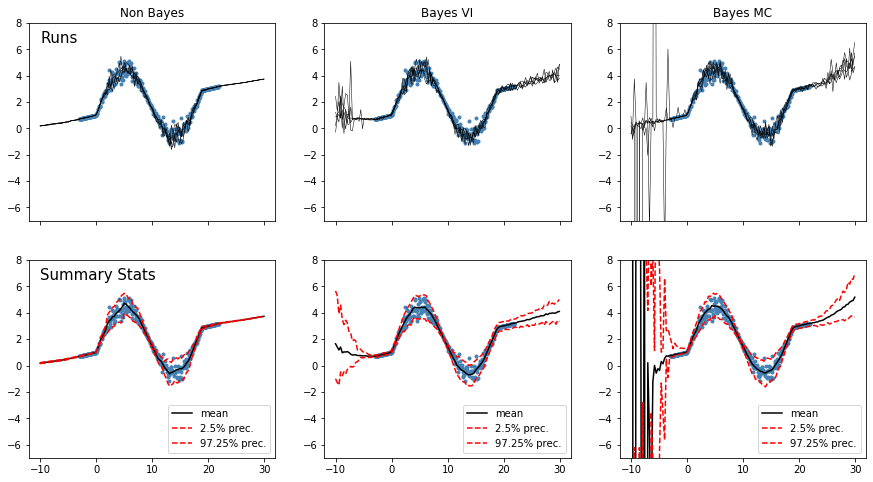

In [29]:
#plt.figure(figsize=(5,25))
f,ax = plt.subplots(2,3,sharex=True, sharey=False,figsize=(15,8))

lines = 5

make_plot_runs(ax[0,0], nobay_cpd[0:lines])
#make_no_bayes_plot(ax[0,1], model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])
ax[0,0].set_title('Non Bayes')
make_plot_runs_avg(ax[1,0],nobay_cpd)
ax[1,0].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,1].set_title('Bayes VI')
make_plot_runs(ax[0,1], vi_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,1], vi_cpd, ylim=[-7,8])
ax[1,1].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,2].set_title('Bayes MC')
make_plot_runs(ax[0,2], mc_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,2], mc_cpd, ylim=[-7,8])
ax[1,2].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

#ax[0,0].axis('off')
ax[0,0].text(-10,6.5, "Runs",fontsize=15,horizontalalignment='left')

#ax[1,0].axis('off')
ax[1,0].text(-10,6.5, "Summary Stats",fontsize=15,horizontalalignment='left')


plt.savefig('ch08_good_cpd.pdf')

plt.show()

In the region where we have training data all approaches yield similar results: They uncertainty captured by the spread of the CPD is large in regions where the data spread is large. All models thus are able to model the aleatoric uncertainty. When we leave the region, where we have data and go into the extrapolation region, the non-Bayesian approach fails. It assumes 95% of the data in an unrealistically narrow region. The Bayesian approaches knows when they don’t know and can express  their uncertainties when leaving known grounds.


### Below is just for creating the animation

Below is the code we used to create the animations:

https://youtu.be/mQrUcUoT2k4 (for VI)
https://youtu.be/0-oyDeR9HrE (for MC dropout) 
https://youtu.be/FO5avm3XT4g (for non-Bayesian).

[1, 3, 3, 2, 1, 1]


Text(0, 0.5, 'y')

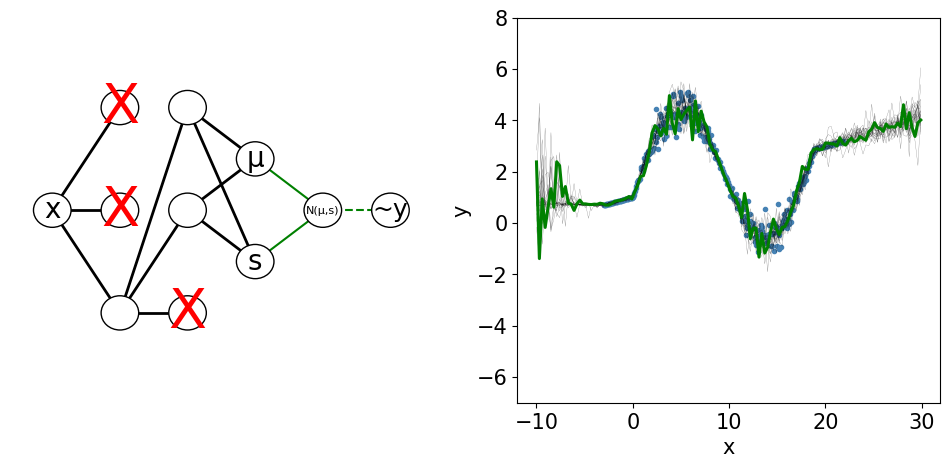

In [66]:
import matplotlib.pyplot as plt
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

def draw_plot_runs(ax, preds, alpha_data=1,ylim=[-7,8], bold=0):
    ax.scatter(x,y,color="steelblue", alpha=alpha_data,marker='.') #observerd 
    for i in range(0,preds.shape[0]):
      ax.plot(x_pred, preds[i],color="black",linewidth=0.2, alpha=0.5)
    ax.plot(x_pred, preds[bold],color="green",linewidth=2.2)
    ax.set_ylim(ylim)

#Edges and nodes for dropout
def make_dropout(layer_sizes,p_drop = 0.3):
    nodes = []
    edges = []   
    p_drop = 0.3
    print(layer_sizes)
    # Makeing Dropout nodes
    for i,n in enumerate(layer_sizes):
        nn = np.ones(n)
        if (i > 0 and i < len(layer_sizes)-3): #We do dropout
            nn[np.random.uniform(0,1,n) < p_drop]=0
        nodes.append(nn)
        
    # Makeing Dropout edges
    for n, (lsa, lsb) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        e = 2.0*np.ones((lsa,lsb))
        e[nodes[n]==0,:] = 0
        edges.append(e)
    return nodes, edges
    
#See also: https://gist.github.com/craffel/2d727968c3aaebd10359  
def draw_neural_net(ax, left, right, bottom, top, layer_sizes,mode,edges=None):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    nodes = None
    if (mode == 'mc'):
        nodes, edges = make_dropout(layer_sizes) 
    
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/6.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
        if n == 3:
            m = 0
            d = plt.Text(n*h_spacing + left, layer_top - m*v_spacing, 'μ', horizontalalignment='center', 
                      size=20,verticalalignment='center',color='black',zorder=4)
            ax.add_artist(d)
            m = 1
            d = plt.Text(n*h_spacing + left, layer_top - m*v_spacing, 's', horizontalalignment='center', 
                      size=20,verticalalignment='center',color='black',zorder=4)
            ax.add_artist(d)
        if n == 4:
            m = 0
            d = plt.Text(n*h_spacing + left, layer_top - m*v_spacing, 'N(μ,s)', horizontalalignment='center', 
                      size=8,verticalalignment='center',color='black',zorder=4)
            ax.add_artist(d)
        if n == 5:
            d = plt.Text(n*h_spacing + left, layer_top - m*v_spacing, '~y',horizontalalignment='center', 
                      size=18,verticalalignment='center',color='black',zorder=4)
            ax.add_artist(d)
            
        if (mode == 'mc'):
            for m in range(layer_size):
                if nodes[n][m] == 0:
                    d = plt.Text(n*h_spacing + left, layer_top - m*v_spacing, 'X', horizontalalignment='center', 
                              size=40,verticalalignment='center',color='red',zorder=4)
                    ax.add_artist(d)
            
            
            
    d = plt.Text(left, layer_top, 'x', horizontalalignment='center', 
                 size=20,verticalalignment='center',color='black', zorder=4)
    ax.add_artist(d)
    
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a): #from 
            for o in range(layer_size_b): #to
                if (n == len(layer_sizes)-2): #Last Layer
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing],c='green',linestyle='--')
                    ax.add_artist(line)
                elif (n == len(layer_sizes)-3): #2nd but last Layer
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing],c='green',linestyle='-')
                    ax.add_artist(line)
                else:
                    size = edges[n][m,o]
                    if (mode == 'vi'): 
                        size = np.random.normal(loc=size,scale=3*size/max_thick,size=1)[0]
                        line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k',linewidth=size)
                        ax.add_artist(line)
                    else:
                        line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k',linewidth=size)
                        ax.add_artist(line)
                        

#fig = plt.figure(figsize=(12, 12))
f,ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].axis('off')
layer_sizes = [1, 3, 3, 2,1, 1]
np.random.seed(42)
max_thick = 5

#Edges for VI and non-Bayes
edges = []
for n, (lsa, lsb) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
    edges.append(np.random.uniform(0,max_thick, (lsa,lsb)))


#mode = 'mc','vi'
draw_neural_net(ax[0], .1, .9, .1, .9, layer_sizes,mode = 'mc',edges=edges) 
draw_plot_runs(ax[1], vi_cpd[0:20], ylim=[-7,8])
plt.xlabel('x')
plt.ylabel('y')

In [56]:
#!pip install imageio-ffmpeg

You should consider upgrading via the 'pip install --upgrade pip' command.


mkdir: cannot create directory ‘./tmp’: File exists
[1, 3, 3, 2, 1, 1]
000 tmp/ho000.png
[1, 3, 3, 2, 1, 1]
001 tmp/ho001.png
[1, 3, 3, 2, 1, 1]
002 tmp/ho002.png
[1, 3, 3, 2, 1, 1]
003 tmp/ho003.png
[1, 3, 3, 2, 1, 1]
004 tmp/ho004.png
[1, 3, 3, 2, 1, 1]
005 tmp/ho005.png
[1, 3, 3, 2, 1, 1]
006 tmp/ho006.png
[1, 3, 3, 2, 1, 1]
007 tmp/ho007.png
[1, 3, 3, 2, 1, 1]
008 tmp/ho008.png
[1, 3, 3, 2, 1, 1]
009 tmp/ho009.png
[1, 3, 3, 2, 1, 1]
010 tmp/ho010.png
[1, 3, 3, 2, 1, 1]
011 tmp/ho011.png
[1, 3, 3, 2, 1, 1]
012 tmp/ho012.png
[1, 3, 3, 2, 1, 1]
013 tmp/ho013.png
[1, 3, 3, 2, 1, 1]
014 tmp/ho014.png
[1, 3, 3, 2, 1, 1]
015 tmp/ho015.png
[1, 3, 3, 2, 1, 1]
016 tmp/ho016.png
[1, 3, 3, 2, 1, 1]
017 tmp/ho017.png
[1, 3, 3, 2, 1, 1]
018 tmp/ho018.png
[1, 3, 3, 2, 1, 1]
019 tmp/ho019.png
[1, 3, 3, 2, 1, 1]
020 tmp/ho020.png
[1, 3, 3, 2, 1, 1]
021 tmp/ho021.png
[1, 3, 3, 2, 1, 1]
022 tmp/ho022.png
[1, 3, 3, 2, 1, 1]
023 tmp/ho023.png
[1, 3, 3, 2, 1, 1]
024 tmp/ho024.png
[1, 3, 3, 2, 1, 1]
025 

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1200, 500) to (1200, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior 

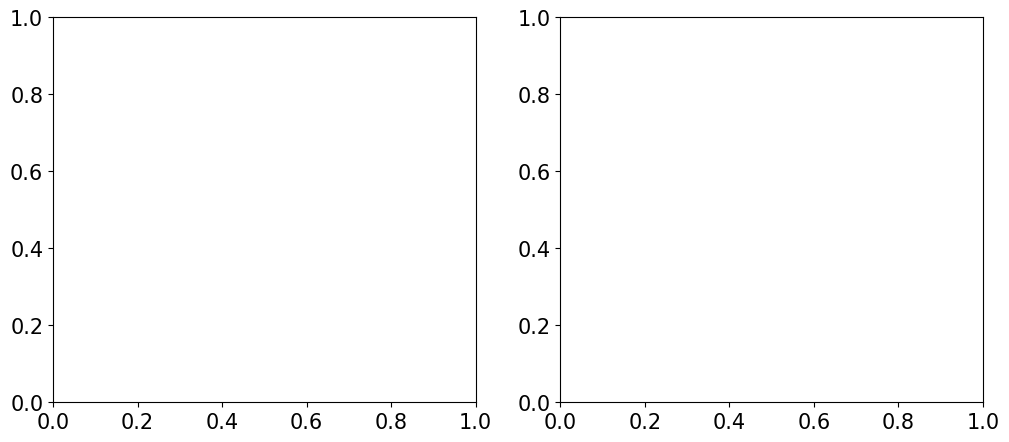

In [69]:
## Creating the images
!mkdir ./tmp
names = []
f,ax = plt.subplots(1,2,figsize=(12 , 5))
for i in range(50):
    ax[0].axis('off')
    draw_neural_net(ax[0], .1, .9, .1, .9, layer_sizes,mode = 'mc',edges=edges) 
    draw_plot_runs(ax[1], mc_cpd[0:50], ylim=[-7,8], bold=i)
    plt.xlabel('x')
    plt.ylabel('y')
    name = 'tmp/ho{:03d}.png'.format(i)
    names.append(name)
    print('{:03d} {}'.format(i,name))
    plt.savefig(name)
    ax[0].cla()
    ax[1].cla()

from imageio import  mimwrite, get_writer
writer = get_writer('sample_mc.mp4', fps=2, quality=6)
for img in names:
  writer.append_data(plt.imread(img))
writer.close()